In [110]:
import pandas as pd
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr
from matplotlib.colors import ListedColormap
from scipy import stats as st
import matplotlib.colors as mcolors

In [111]:
file = pd.read_table('/home/janneae/cns/steps/discretized_9_6bins.features', dtype=str)
survivaldata = pd.read_table('/home/janneae/TCGA/DerivedData/TCGA_survival_data_clean.txt')
mutations = pd.read_table('../data/all_muts_pass_and_polyphen.txt', sep=' ')
gene_exp = pd.read_table('../data/all_tcga_gene_exp.txt', sep='\t')
maf = pd.read_table('../data/all_tcga_maf.txt', sep=' ')
cin_loc = pd.read_table('../data/cin_locations.txt')
sanchez_vega = pd.read_table('../data/sanchez_vega_pws_1026.csv', sep=';')

/scratch/64074874/ipykernel_12179/1198093174.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_table('../data/all_muts_pass_and_polyphen.txt', sep=' ')


In [112]:
lda = LdaModel.load(f'../steps/gensim/lda/lda_t5_f10.model')
df = file.drop(['Sample', 'Chr'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

## Feature distributions

In [4]:
topics = lda.show_topics(num_words=50, formatted=False)

out = []
for i, topic in topics:
    topic = sorted(topic)
    for word, weight in topic:
        out.append([word, i + 1, weight])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'weight'])
prefixes = ['CN', 'SegSize', 'Dist2Cent', 'SegVal', 'LOH', 'SizeDipSeg', 'CpCN', 'Dist2CNV', 'GCcSeg']

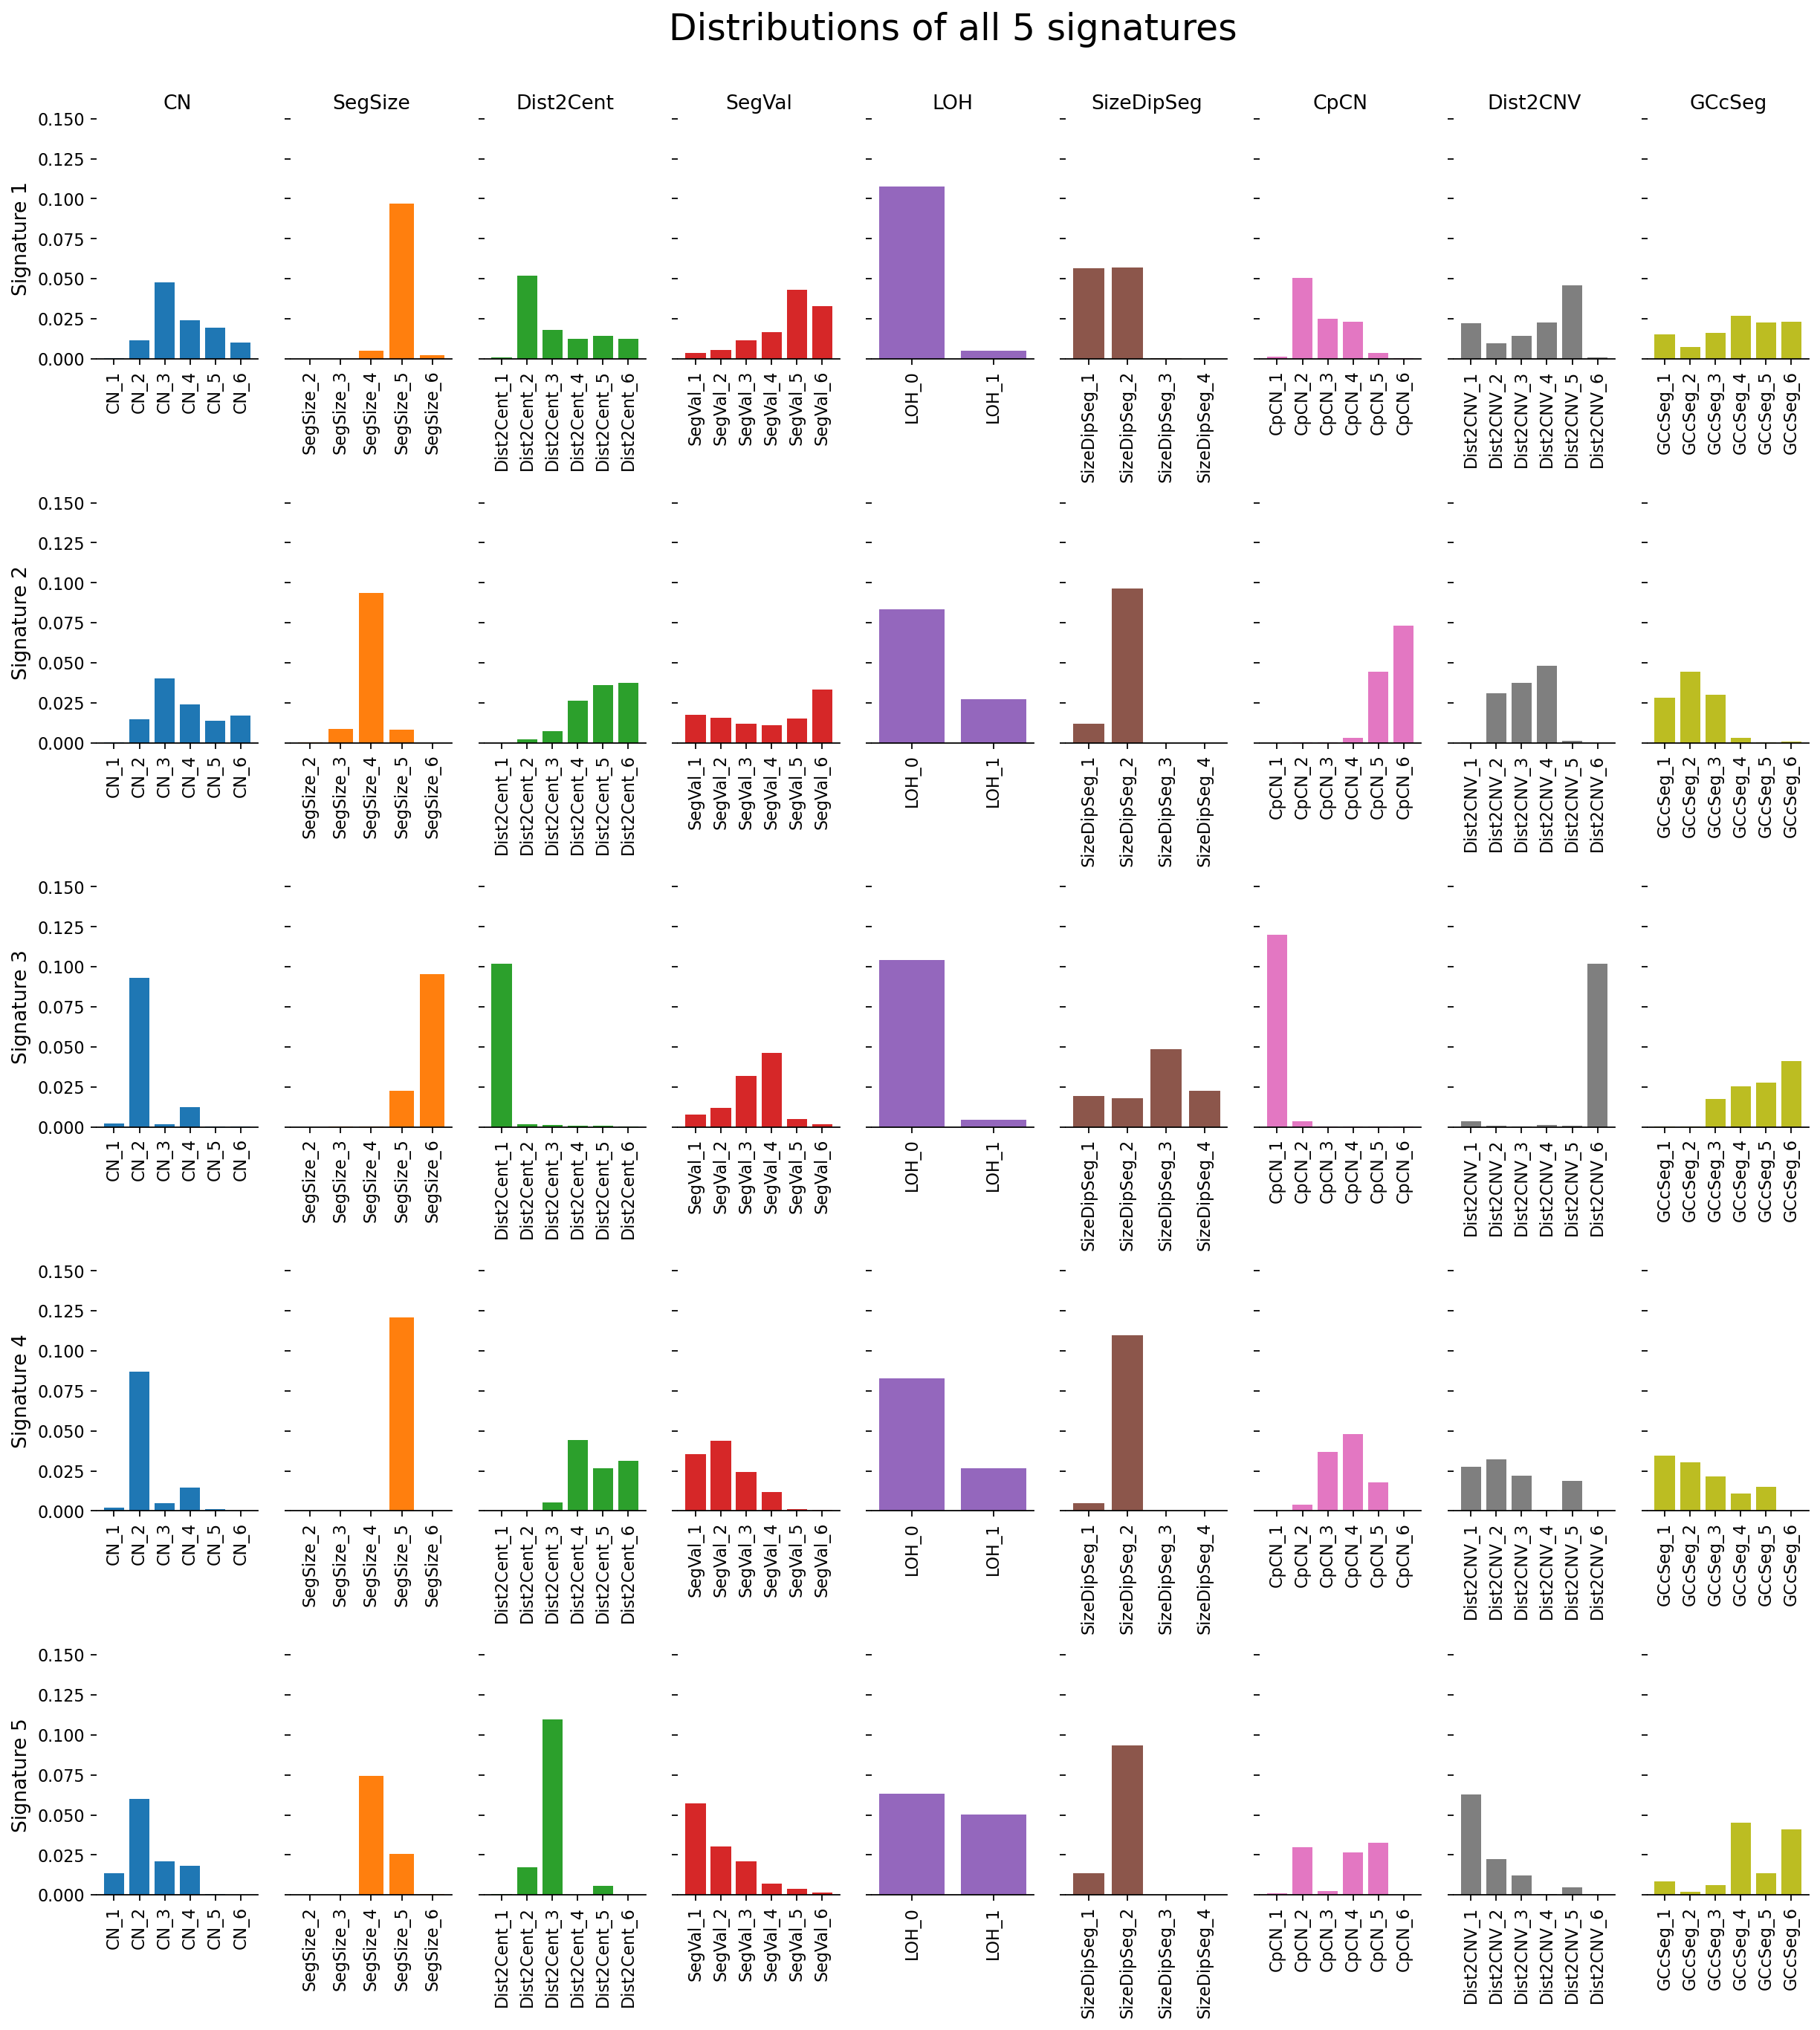

In [5]:
fig, axes = plt.subplots(5, 9, figsize=(18,18), sharey=True, dpi=160)

palette = sns.color_palette('tab10')

for i, ax in enumerate(axes):
    data = df[df['topic_id']==i+1]
    ax[0].set_ylabel(f'Signature {i+1}', fontsize=12)
    for j in range(0, 9):
        ax[j].bar(x='word', height="weight", 
                  data=data[data['word'].str.startswith(prefixes[j])], 
                  width=0.8, color=palette[j])
        if i == 0:
            ax[j].title.set_text(prefixes[j])
    
for ax in axes.flatten():
    ax.set_ylim(0, 0.15)
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.93, wspace=0.2, hspace=0.6)
fig.suptitle('Distributions of all 5 signatures', fontsize=22)
fig.savefig('../figures/all_signatures.pdf')
plt.show()

## Heatmap with signature weights

In [113]:
def create_heatmap(model, df):
    topics = lda.get_document_topics(bow = bow_corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Sample'])
    new_df['Chr'] = df['Chr']
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr')
    return new_df

In [114]:
weights_df = create_heatmap(lda, file)
weights_df = weights_df[weights_df['Chr'] != 23]
heatmap_df = weights_df.drop('Sample', axis = 1).set_index('Chr').transpose()

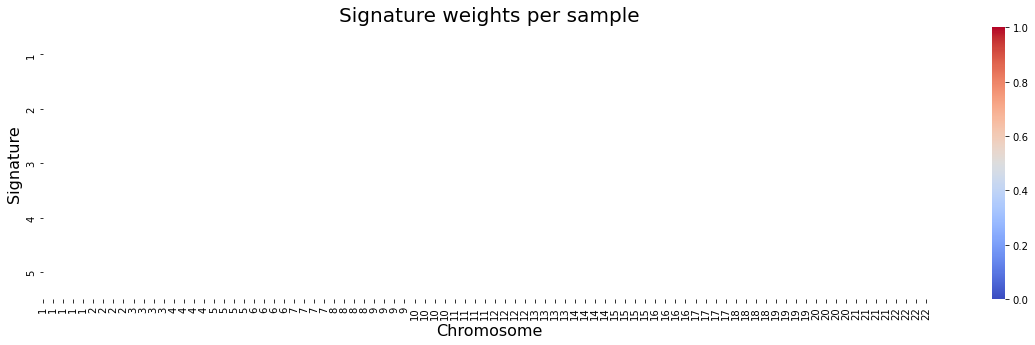

In [115]:
plt.figure(figsize=(20,5))
ax = sns.heatmap(heatmap_df, cmap='coolwarm', vmin=0, vmax=1, linewidth=0.5)
ax.tick_params(axis="both", which="major", labelsize=10)
plt.xlabel('Chromosome', fontsize=16)
plt.ylabel('Signature', fontsize=16)
plt.title("Signature weights per sample", fontsize=20)
plt.savefig('../figures/heatmap.pdf')
plt.show()

## Correlating signatures with CIN variables

In [61]:
cin = pd.read_table("../data/all_tcga_cin_measures.txt", sep=" ").set_index('sample_id').reindex(index=weights_df['Sample']).reset_index()

,Sample,Telomeric.AI,Mean.size,Interstitial.AI,Mean.Size,Whole.chr.AI,Telomeric.LOH,Mean.size.1,Interstitial.LOH,Mean.Size.1,...,Ploidy,Aberrant.cell.fraction,cancerType,lst,hrd,GII,wGII,FLOH,wFLOH,cnt_chr
0,TCGA-02-0001,6.0,1.993161e+07,18.0,1.293457e+07,3.0,2.0,17881598.5,11.0,1.464080e+07,...,2.315302,0.58,NaN,9.0,6.0,0.520588,0.462361,0.201262,0.231483,52.5
1,TCGA-AP-A054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-C4-A0F7,24.0,1.787304e+07,117.0,9.834940e+06,0.0,14.0,19850489.0,45.0,1.562689e+07,...,3.270631,0.62,NaN,21.0,22.0,0.704474,0.662600,0.344939,0.355221,85.0
3,TCGA-DJ-A3US,0.0,NaN,3.0,4.811540e+06,0.0,0.0,NaN,3.0,4.811540e+06,...,1.998908,0.79,NaN,0.0,0.0,0.007034,0.004985,0.005837,0.003953,43.0
4,TCGA-TS-A8AI,6.0,1.943115e+07,19.0,2.256094e+07,1.0,5.0,21351494.4,19.0,2.256094e+07,...,1.790394,0.53,NaN,12.0,13.0,0.262152,0.233425,0.254523,0.222219,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168405,TCGA-L5-A88T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168406,TCGA-BP-4760,0.0,NaN,1.0,2.749460e+06,0.0,0.0,NaN,1.0,2.749460e+06,...,2.092634,0.32,NaN,0.0,0.0,0.000190,0.000273,0.001246,0.002107,44.0
168407,TCGA-AL-3473,2.0,9.036938e+07,0.0,NaN,1.0,1.0,90442517.0,0.0,NaN,...,2.059795,0.34,NaN,1.0,3.0,0.097060,0.089527,0.064322,0.066516,42.5
168408,TCGA-GU-AATP,11.0,2.791588e+07,63.0,8.621702e+06,1.0,4.0,32569841.0,17.0,1.031331e+07,...,2.809372,0.66,NaN,8.0,4.0,0.509183,0.501556,0.154506,0.191137,64.5


In [11]:
combined_cin = weights_df.reset_index(drop=True)
combined_cin['Telomeric.AI'] = cin['Telomeric.AI']
combined_cin['lst'] = cin['lst']
combined_cin['hrd'] = cin['hrd']
combined_cin['wGII'] = cin['wGII']
combined_cin['ploidy'] = cin['Ploidy']
combined_cin['hrd_score'] = cin['lst'] + cin['Telomeric.AI'] + cin['hrd']
combined_cin['wFLOH'] = cin['wFLOH']
combined_cin = combined_cin.dropna().reset_index(drop=True)

,Sample,Chr,1,2,3,4,5,Telomeric.AI,lst,hrd,wGII,ploidy,hrd_score,wFLOH
0,TCGA-02-0001,1,0.291410,0.023780,0.396947,0.014247,0.273616,6.0,9.0,6.0,0.462361,2.315302,21.0,0.231483
1,TCGA-C4-A0F7,1,0.037110,0.919098,0.017613,0.014241,0.011939,24.0,21.0,22.0,0.662600,3.270631,67.0,0.355221
2,TCGA-DJ-A3US,1,0.567111,0.388980,0.017685,0.014279,0.011946,0.0,0.0,0.0,0.004985,1.998908,0.0,0.003953
3,TCGA-TS-A8AI,1,0.039091,0.024253,0.017761,0.906943,0.011952,6.0,12.0,13.0,0.233425,1.790394,31.0,0.222219
4,TCGA-29-1711,1,0.127277,0.828753,0.017758,0.014255,0.011956,28.0,32.0,20.0,0.477439,1.934815,80.0,0.420743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155271,TCGA-BP-4326,22,0.044877,0.023947,0.904915,0.014311,0.011950,4.0,3.0,4.0,0.028022,1.957887,11.0,0.058627
155272,TCGA-BP-4760,22,0.498307,0.023580,0.017741,0.448421,0.011951,0.0,0.0,0.0,0.000273,2.092634,0.0,0.002107
155273,TCGA-AL-3473,22,0.768512,0.187623,0.017646,0.014265,0.011954,2.0,1.0,3.0,0.089527,2.059795,6.0,0.066516
155274,TCGA-GU-AATP,22,0.443454,0.023919,0.017663,0.014261,0.500703,11.0,8.0,4.0,0.501556,2.809372,23.0,0.191137


In [12]:
combined_df = weights_df.reset_index()
combined_df['Age_at_diagnosis'] = survivaldata['age_at_initial_pathologic_diagnosis']
combined_df = combined_df.dropna()
combined_df

,index,Sample,Chr,1,2,3,4,5,Age_at_diagnosis
0,0,TCGA-02-0001,1,0.291410,0.023780,0.396947,0.014247,0.273616,58.0
1,55108,TCGA-AP-A054,1,0.505919,0.023934,0.443955,0.014247,0.011945,44.0
2,76107,TCGA-C4-A0F7,1,0.037110,0.919098,0.017613,0.014241,0.011939,23.0
3,99958,TCGA-DJ-A3US,1,0.567111,0.388980,0.017685,0.014279,0.011946,23.0
4,160885,TCGA-TS-A8AI,1,0.039091,0.024253,0.017761,0.906943,0.011952,30.0
...,...,...,...,...,...,...,...,...,...
11155,151755,TCGA-OR-A5LM,2,0.221060,0.735032,0.017655,0.014305,0.011947,75.0
11156,24312,TCGA-4C-A93U,2,0.398608,0.024164,0.017754,0.547527,0.011947,79.0
11157,107135,TCGA-E2-A14Q,2,0.828967,0.023880,0.120965,0.014248,0.011941,51.0
11158,59111,TCGA-B0-4713,2,0.262558,0.693576,0.017640,0.014283,0.011943,50.0


In [13]:
def correlate(cin, survival, val):
    age = []
    tel = []
    lst = []
    hrd = []
    hrd_score = []
    ploidy = []
    wGII = []
    wFLOH = []
    
    for i in range(1, 6):
        age.append(pearsonr(survival[f'{i}'], survival['Age_at_diagnosis'])[val])
        tel.append(pearsonr(cin[f'{i}'], cin['Telomeric.AI'])[val])
        lst.append(pearsonr(cin[f'{i}'], cin['lst'])[val])
        hrd.append(pearsonr(cin[f'{i}'], cin['hrd'])[val])
        hrd_score.append(pearsonr(cin[f'{i}'], cin['hrd_score'])[val])
        ploidy.append(pearsonr(cin[f'{i}'], cin['ploidy'])[val])
        wGII.append(pearsonr(cin[f'{i}'], cin['wGII'])[val])
        wFLOH.append(pearsonr(cin[f'{i}'], cin['wFLOH'])[val])
    
    corr_df = pd.DataFrame([1, 2, 3, 4, 5], columns=['Signature'])
    corr_df['Age_at_diagnosis'] = age
    corr_df['Telomeric.AI'] = tel
    corr_df['LST'] = lst
    corr_df['HRD'] = hrd
    corr_df['HRD_score'] = hrd_score
    corr_df['Ploidy'] = ploidy
    corr_df['wGII'] = wGII
    corr_df['wFLOH'] = wFLOH
    
    corr_df = corr_df.set_index('Signature')
    corr_df = corr_df.transpose()
    
    return corr_df

In [14]:
corr_df = correlate(combined_cin, combined_df, 0)
pval_df = correlate(combined_cin, combined_df, 1)

In [15]:
psig = 0.001/176000

for i in range(1, 5):
    for j in range(1, 7):
        if pval_df[i][j] > psig:
            corr_df[i][j] = 0
corr_df

Signature,1,2,3,4,5
Age_at_diagnosis,0.015695,-0.009876,-0.014821,0.009380,-0.004732
Telomeric.AI,-0.037755,0.394413,-0.344941,-0.110110,0.084935
LST,-0.057731,0.348804,-0.294785,-0.079814,0.073809
HRD,-0.071291,0.296575,-0.277816,-0.039812,0.095970
HRD_score,-0.058074,0.383068,-0.336253,-0.088119,0.091008
Ploidy,0.181354,0.134384,-0.147190,-0.166779,-0.048656
wGII,0.062925,0.303563,-0.334189,-0.120780,0.070144
wFLOH,-0.060298,0.258639,-0.282001,-0.030768,0.130834


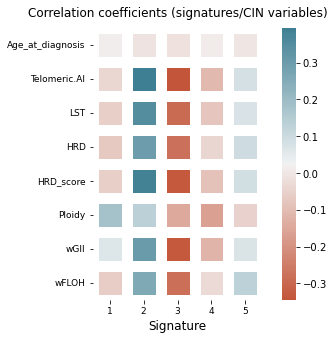

In [106]:
palette = sns.diverging_palette(20, 220, as_cmap=True)

f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(
    corr_df[corr_df!=0],
    # vmin=-0.5, vmax=0.5, 
    cmap=palette,
    square=True,
    linewidths=11)
    
plt.xlabel("Signature", fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.title("Correlation coefficients (signatures/CIN variables)", size=12, y=1.02)
plt.savefig('../figures/correlation_matrix.pdf')

## Difference in mean signature weights

In [31]:
high_impact = mutations[mutations['PolyPhen_num']>0.99]
gene_list = list(high_impact.drop_duplicates(subset = ["Hugo_Symbol"])['Hugo_Symbol'])

In [87]:
mut = weights_df.reset_index(drop=True)
mut = mut.rename(columns = {'Sample': 'sampleID'})
# mut= mut.drop_duplicates(subset = ["sampleID"])
mut = pd.merge(left = mut, right = maf[['sampleID', 'mutatated_genes']], on='sampleID')

gene_list = ['TP53', 'PTEN', 'NF1', 'MYC', 'CDK12', 'CCNE1', 'BRCA2', 'BRCA1']
# gene_list = list(cin_loc['Gene'])

for gene in gene_list:
    mut[gene] = np.where(mut['mutatated_genes'].str.contains(gene), True, False)

mut

,sampleID,Chr,1,2,3,4,5,mutatated_genes,TP53,PTEN,NF1,MYC,CDK12,CCNE1,BRCA2,BRCA1
0,TCGA-C4-A0F7,1,0.037110,0.919098,0.017613,0.014241,0.011939,"HNF1A, TP53",True,False,True,False,False,False,False,False
1,TCGA-C4-A0F7,2,0.036457,0.919694,0.017634,0.014270,0.011945,"HNF1A, TP53",True,False,True,False,False,False,False,False
2,TCGA-C4-A0F7,3,0.036371,0.919767,0.017649,0.014269,0.011944,"HNF1A, TP53",True,False,True,False,False,False,False,False
3,TCGA-C4-A0F7,4,0.037275,0.752168,0.017627,0.014254,0.178676,"HNF1A, TP53",True,False,True,False,False,False,False,False
4,TCGA-C4-A0F7,5,0.035478,0.920718,0.017594,0.014261,0.011948,"HNF1A, TP53",True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99875,TCGA-XF-A8HC,18,0.171206,0.784897,0.017681,0.014263,0.011952,ERBB2,False,False,False,False,False,False,False,False
99876,TCGA-XF-A8HC,19,0.713974,0.024259,0.017679,0.014244,0.229844,ERBB2,False,False,False,False,False,False,False,False
99877,TCGA-XF-A8HC,20,0.719897,0.023384,0.230515,0.014254,0.011950,ERBB2,False,False,False,False,False,False,False,False
99878,TCGA-XF-A8HC,21,0.627291,0.024031,0.322422,0.014308,0.011947,ERBB2,False,False,False,False,False,False,False,False


In [88]:
sig = [1, 2, 3, 4, 5]
gene_df = pd.DataFrame(sig, columns=['Signature'])

for gene in gene_list:
    p_values = []
    for i in range(1, len(sig)+1):
        a = mut[mut[gene] == True][str(i)]
        b = mut[mut[gene] == False][str(i)]
        if len(a) == 0 or len(b) == 0: break
        else: 
            p = st.mannwhitneyu(x=a, y=b, alternative='two-sided')[1]
            p_values.append(p)
    if len(p_values) == 5: gene_df[gene] = p_values
    else: continue
gene_df = gene_df.set_index('Signature').transpose()
gene_df

Signature,1,2,3,4,5
TP53,0.173708,0.000000e+00,0.000000e+00,0.000423,1.052232e-86
PTEN,0.002908,1.612273e-15,6.029474e-11,0.000755,5.104076e-02
NF1,0.000068,4.988410e-01,7.364591e-06,0.000952,2.162009e-01
MYC,0.270429,2.415173e-01,1.228743e-02,0.048901,5.949807e-01
CDK12,0.393557,1.763932e-15,1.013576e-06,0.000035,6.725717e-02
BRCA2,0.107212,6.997101e-06,7.240293e-07,0.145783,2.293856e-01
BRCA1,0.255439,2.274526e-18,6.553381e-08,0.510760,8.065847e-02


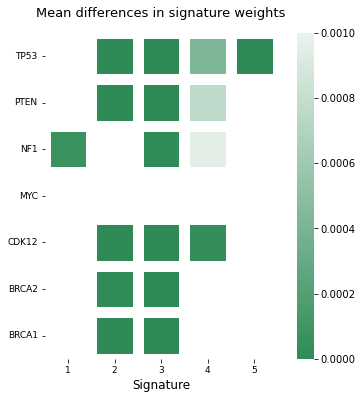

In [105]:
alpha = 0.001
palette = sns.light_palette("seagreen", reverse=True, as_cmap=True)
# palette = sns.diverging_palette(10, 220, as_cmap=True)

f, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(
    gene_df[gene_df<alpha],
    vmin=0, vmax=alpha, 
    cmap=palette,
    square=True,
    linewidths=11)
    
plt.xlabel("Signature", fontsize=12)
plt.yticks(rotation=0)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.title("Mean differences in signature weights", fontsize=13, y=1.03)
plt.savefig('../figures/correlation_matrix_cin70.pdf')

## Gene Expression

In [23]:
gene_expT = gene_exp.transpose()
gene_expT['Sample'] = gene_expT.index
gene_expT

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C,Sample
TCGA-19-1787,5.5438,2.8974,5.2327,1.23330,2.90900,2.7826,2.64180,5.58980,3.62890,3.25410,...,-9.9658,2.77000,5.46500,-9.9658,3.0446,-9.9658,4.98420,-9.9658,-6.50640,TCGA-19-1787
TCGA-S9-A7J2,5.3709,-1.7809,4.6972,2.33660,1.51150,1.5514,1.14470,3.40340,5.46730,4.46340,...,-9.9658,2.66700,5.40130,-9.9658,3.1908,-9.9658,2.80760,-9.9658,-4.29340,TCGA-S9-A7J2
TCGA-G3-A3CH,5.4422,-3.6370,4.3111,1.93840,-0.19515,1.6659,8.60775,4.64695,4.74575,2.05375,...,-9.9658,-0.32265,3.93430,-9.9658,0.9153,-9.9658,1.01890,-9.9658,-9.96580,TCGA-G3-A3CH
TCGA-EK-A2RE,4.7077,-9.9658,5.8585,2.08100,2.86220,-0.2159,3.10790,4.89340,4.03130,3.07910,...,-9.9658,-0.23280,4.73400,-9.9658,6.1416,-9.9658,-1.21420,-9.9658,-9.96580,TCGA-EK-A2RE
TCGA-44-6778,3.9800,-6.7119,5.3509,2.68705,1.63215,5.5077,4.90205,5.10775,4.21175,3.97765,...,-9.9658,1.26620,4.28085,-7.0004,3.4035,-9.9658,1.88605,-9.9658,-1.40405,TCGA-44-6778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-95-7947,5.8370,-1.5522,6.3884,3.82080,3.46870,3.3264,5.79500,6.34180,5.77450,4.81610,...,-9.9658,1.22710,5.69460,-9.9658,6.0492,-9.9658,1.29920,-9.9658,-9.96580,TCGA-95-7947
TCGA-VQ-AA6F,3.2988,-9.9658,5.1526,2.59480,2.22060,1.3846,4.04620,5.09640,6.39900,6.31540,...,-9.9658,0.82460,4.27060,-5.5735,5.6473,-9.9658,-1.99420,-9.9658,-9.96580,TCGA-VQ-AA6F
TCGA-BR-8588,3.2959,-3.1714,5.1244,2.40900,2.97470,2.6278,4.69600,5.04840,3.35490,3.33500,...,-9.9658,0.08540,4.28330,-9.9658,2.9128,-9.9658,1.51150,-9.9658,-9.96580,TCGA-BR-8588
TCGA-24-2254,6.5220,-1.6850,5.6372,2.52880,2.98390,3.1507,6.21080,5.74070,4.91320,4.99150,...,-9.9658,0.43400,5.31290,-9.9658,3.3883,-9.9658,3.42100,-9.9658,-9.96580,TCGA-24-2254


In [24]:
exp = weights_df.reset_index(drop=True).drop(['Chr'], axis = 1).drop_duplicates(subset = ["Sample"])
exp.columns = ['Sample', 'Sig1', 'Sig2', 'Sig3', 'Sig4', 'Sig5']
exp = pd.merge(left = exp, right = gene_expT, on = 'Sample')

In [25]:
exp.index = exp['Sample']
exp = exp.drop(['Sample'], axis = 1)
exp

,Sig1,Sig2,Sig3,Sig4,Sig5,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-C4-A0F7,0.037110,0.919098,0.017613,0.014241,0.011939,5.2068,-5.5735,6.7803,2.2663,3.8360,...,-9.9658,-9.9658,0.2029,5.8958,-9.9658,4.4122,-9.9658,-4.0350,-9.9658,-9.9658
TCGA-DJ-A3US,0.567111,0.388980,0.017685,0.014279,0.011946,4.9199,-9.9658,5.3320,2.9948,1.4441,...,-9.9658,-9.9658,0.2998,5.4202,-9.9658,4.2396,-9.9658,1.6093,-9.9658,-5.0116
TCGA-TS-A8AI,0.039091,0.024253,0.017761,0.906943,0.011952,3.6335,-5.5735,5.6562,1.9302,2.6302,...,-9.9658,-9.9658,-0.0725,4.6404,-9.9658,5.4002,-9.9658,2.4035,-9.9658,-9.9658
TCGA-29-1711,0.127277,0.828753,0.017758,0.014255,0.011956,4.8640,-9.9658,6.3248,2.7051,2.6533,...,-9.9658,-9.9658,0.0854,4.2548,-9.9658,5.5069,-9.9658,2.7292,-9.9658,-9.9658
TCGA-TS-A8AF,0.035328,0.920811,0.017658,0.014258,0.011945,3.7898,-9.9658,5.4909,1.9712,1.6466,...,-9.9658,-9.9658,1.1184,4.1482,-4.6082,5.0418,-9.9658,2.8681,-9.9658,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-FR-A8YC,0.660550,0.023319,0.289960,0.014231,0.011939,3.7867,-3.0469,4.3328,2.5707,1.8078,...,-9.9658,-9.9658,0.7664,4.2578,-9.9658,1.1833,-9.9658,1.5064,-9.9658,1.5709
TCGA-ZF-A9RC,0.137029,0.819012,0.017749,0.014255,0.011955,5.5289,-9.9658,5.8215,1.9895,3.1924,...,-9.9658,-9.9658,1.7532,5.1575,-2.8262,5.3463,-6.5064,-0.7588,-9.9658,-9.9658
TCGA-AB-2896,0.555509,0.024324,0.017627,0.390593,0.011947,-0.8339,-9.9658,5.1879,3.0688,4.0207,...,-9.9658,-9.9658,2.3898,4.0251,-9.9658,0.8246,-9.9658,0.5370,-9.9658,-9.9658


In [26]:
exp_final = exp.drop(['Sig1', 'Sig2', 'Sig3', 'Sig4', 'Sig5'], axis = 1)
exp_final

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-C4-A0F7,5.2068,-5.5735,6.7803,2.2663,3.8360,0.0854,4.7318,4.6136,3.9682,3.0774,...,-9.9658,-9.9658,0.2029,5.8958,-9.9658,4.4122,-9.9658,-4.0350,-9.9658,-9.9658
TCGA-DJ-A3US,4.9199,-9.9658,5.3320,2.9948,1.4441,3.5461,5.1851,5.2533,4.0926,4.0046,...,-9.9658,-9.9658,0.2998,5.4202,-9.9658,4.2396,-9.9658,1.6093,-9.9658,-5.0116
TCGA-TS-A8AI,3.6335,-5.5735,5.6562,1.9302,2.6302,2.2299,7.2257,6.5179,2.9857,3.2915,...,-9.9658,-9.9658,-0.0725,4.6404,-9.9658,5.4002,-9.9658,2.4035,-9.9658,-9.9658
TCGA-29-1711,4.8640,-9.9658,6.3248,2.7051,2.6533,2.2421,3.8749,5.1165,3.7571,4.3428,...,-9.9658,-9.9658,0.0854,4.2548,-9.9658,5.5069,-9.9658,2.7292,-9.9658,-9.9658
TCGA-TS-A8AF,3.7898,-9.9658,5.4909,1.9712,1.6466,3.2127,7.7617,6.0199,3.3105,3.6691,...,-9.9658,-9.9658,1.1184,4.1482,-4.6082,5.0418,-9.9658,2.8681,-9.9658,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-FR-A8YC,3.7867,-3.0469,4.3328,2.5707,1.8078,1.7912,2.9600,4.7377,3.4007,3.2587,...,-9.9658,-9.9658,0.7664,4.2578,-9.9658,1.1833,-9.9658,1.5064,-9.9658,1.5709
TCGA-ZF-A9RC,5.5289,-9.9658,5.8215,1.9895,3.1924,0.7058,2.7161,5.4460,2.3732,2.5585,...,-9.9658,-9.9658,1.7532,5.1575,-2.8262,5.3463,-6.5064,-0.7588,-9.9658,-9.9658
TCGA-AB-2896,-0.8339,-9.9658,5.1879,3.0688,4.0207,5.6282,3.7877,4.9440,4.7555,5.3733,...,-9.9658,-9.9658,2.3898,4.0251,-9.9658,0.8246,-9.9658,0.5370,-9.9658,-9.9658


In [ ]:
correlation_df = pd.DataFrame(columns=exp_final.columns, index=['Signature_1', 'Signature_2', 'Signature_3', 'Signature_4', 'Signature_5'])

for signature in range(1, 6):
    for gene in correlation_df.columns:
        correlation_df[gene][f'Signature_{signature}'] = st.pearsonr(exp[f'Sig{signature}'], exp_final[gene])[0]
correlation_df

In [ ]:
pval_df = pd.DataFrame(columns=exp_final.columns, index=['Signature_1', 'Signature_2', 'Signature_3', 'Signature_4', 'Signature_5'])

for signature in range(1, 6):
    for gene in pval_df.columns:
        pval_df[gene][f'Signature_{signature}'] = st.pearsonr(exp[f'Sig{signature}'], exp_final[gene])[1]
pval_df

In [ ]:
pval_df.to_csv("/home/janneae/cns/steps/allgenes.p_vals", header=True, sep=' ')
correlation_df.to_csv("/home/janneae/cns/steps/allgenes.correlation", header=True, sep=' ')

In [28]:
pval_df = pd.read_table('/home/janneae/cns/steps/allgenes.p_vals', sep=' ')
pval_df = pval_df.set_index('Unnamed: 0')
pval_df.index = pval_df.index.rename('Signature')
pval_df = pval_df.fillna(1)
pval_df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,0.012675,0.596778,8.950103e-01,1.227968e-17,8.658222e-14,4.735833e-05,1.825219e-13,8.016004e-01,0.013779,1.094065e-03,...,8.367640e-01,0.475951,0.027640,0.425972,3.885032e-04,0.321779,0.316571,1.520074e-03,0.730534,1.579705e-01
Signature_2,0.000136,0.000018,3.656948e-71,8.123128e-06,6.076380e-129,3.252016e-21,5.374413e-03,5.115735e-11,0.686936,7.372090e-11,...,1.049236e-08,0.000022,0.003073,0.000009,3.470473e-05,0.444396,0.001043,1.286341e-11,0.000358,1.500337e-07
Signature_3,0.208807,0.000005,2.243783e-40,1.807712e-03,5.939330e-108,4.124504e-21,7.981075e-06,9.328298e-01,0.014726,1.614572e-06,...,1.836728e-04,0.000037,0.000148,0.000036,1.189237e-01,0.164947,0.000974,6.083078e-12,0.023596,2.327029e-04
Signature_4,0.000002,0.515798,6.185101e-16,2.180797e-18,8.848768e-44,7.824547e-01,8.864398e-10,7.986753e-12,0.474493,1.127786e-07,...,2.029792e-03,0.031812,0.088751,0.042044,8.842618e-11,0.018021,0.112780,5.229333e-01,0.130458,1.727722e-05
Signature_5,0.001759,0.826763,8.625055e-05,4.170872e-10,3.684303e-20,1.862607e-01,1.371215e-04,9.383799e-03,0.714224,3.988410e-06,...,4.236906e-02,0.868621,0.008071,0.105247,8.674419e-01,0.069017,0.109953,6.590476e-01,0.149203,6.165859e-01


In [53]:
pval_log = -np.log10(pval_df)
pval_log

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,1.897052,0.224187,0.048172,16.910813,13.062571,4.324604,12.738685,0.096042,1.860776,2.960957,...,0.077397,0.322438,1.558459,0.370619,3.410605,0.492443,0.499529,2.818135,0.136360,0.801424
Signature_2,3.865639,4.736504,70.436881,5.090277,128.216355,20.487847,2.269669,10.291092,0.163083,10.132409,...,7.979127,4.648249,2.512390,5.061165,4.459611,0.352230,2.981590,10.890644,3.446641,6.823811
Signature_3,0.680254,5.307632,39.649019,2.742871,107.226263,20.384628,5.097939,0.030198,1.831909,5.791943,...,3.735955,4.432689,3.828834,4.437997,0.924732,0.782655,3.011602,11.215877,1.627168,3.633198
Signature_4,5.627088,0.287521,15.208653,17.661385,43.053117,0.106541,9.052351,11.097630,0.323770,6.947773,...,2.692548,1.497416,1.051826,1.376292,10.053419,1.744229,0.947768,0.281554,0.884528,4.762526
Signature_5,2.754651,0.082619,4.064238,9.379773,19.433645,0.729879,3.862895,2.027621,0.146166,5.399200,...,1.372951,0.061170,2.093085,0.977791,0.061760,1.161043,0.958794,0.181083,0.826223,0.210006


In [30]:
correlation_df = pd.read_table('/home/janneae/cns/steps/allgenes.correlation', sep=' ')
correlation_df = correlation_df.set_index('Unnamed: 0')
correlation_df.index = correlation_df.index.rename('Signature')
correlation_df = correlation_df.fillna(0)
correlation_df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,0.031690,0.006727,-0.001678,0.108404,0.094647,0.051698,0.093397,0.003195,0.031311,0.041501,...,0.002620,0.009064,0.027999,0.010123,-0.045090,0.012599,0.012735,0.040304,-0.004380,0.017953
Signature_2,0.048481,-0.054436,0.223926,0.056692,0.300090,-0.119787,-0.035386,0.083367,0.005125,0.082676,...,0.072672,0.053860,0.037630,0.056509,-0.052610,0.009725,0.041672,-0.085930,0.045367,0.066716
Signature_3,-0.015981,0.058037,-0.167948,-0.039660,-0.275222,0.119474,0.056740,0.001072,-0.031007,-0.060935,...,-0.047537,-0.052429,-0.048215,-0.052465,0.019826,0.017656,-0.041919,0.087289,-0.028778,-0.046776
Signature_4,-0.059963,0.008263,-0.102545,-0.110890,-0.175082,-0.003511,-0.077813,-0.086797,-0.009094,-0.067379,...,-0.039224,-0.027293,-0.021640,-0.025848,0.082329,-0.030069,-0.020163,-0.008123,-0.019228,-0.054605
Signature_5,-0.039761,0.002783,-0.049896,-0.079317,-0.116548,-0.016806,-0.048461,-0.033024,-0.004656,-0.058595,...,-0.025807,0.002103,-0.033676,-0.020597,0.002122,-0.023118,-0.020323,-0.005611,-0.018339,0.006367


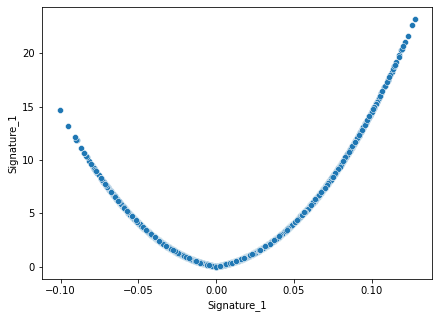

In [55]:
plt.figure(figsize=(7,5))
ax1 = sns.scatterplot(x = correlation_df.iloc[0], y = pval_log.iloc[0])

In [32]:
cin_70 = list(cin_loc['Gene'])

In [72]:
pval_df_70

,NDUFAB1,NCAPD2,MCM10,ELAVL1,TRIP13,MCM2,UNG,AURKA,TPX2,KIF4A,...,RRM1,PBK,FEN1,RRM2,DHCR7,ZWILCH,UBE2C,CKAP5,AURKB,PRC1
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,6.177771e-01,8.878591e-01,6.987678e-03,5.631871e-01,6.988667e-03,1.509661e-01,8.405929e-01,4.920886e-03,9.943730e-04,3.019492e-05,...,1.265849e-02,1.087325e-02,1.923625e-01,1.593038e-04,7.650961e-01,6.673183e-02,1.447313e-03,8.462326e-01,6.139234e-03,3.731635e-02
Signature_2,2.268384e-23,7.463031e-80,3.148957e-143,4.061065e-39,1.566327e-170,2.808274e-107,1.221039e-39,1.405930e-175,4.529092e-172,1.232060e-152,...,4.389715e-26,2.661121e-126,7.375391e-97,1.204900e-114,3.155152e-21,6.592278e-84,1.663062e-185,4.727986e-35,7.484550e-146,2.486411e-143
Signature_3,8.582685e-26,3.976304e-60,1.142356e-122,8.136297e-22,6.956658e-151,2.991472e-91,9.276222e-31,4.210667e-177,1.141703e-173,9.931678e-168,...,1.052438e-39,2.755450e-146,3.001860e-119,6.521982e-117,3.562919e-30,4.104327e-77,1.694374e-179,9.795446e-46,1.317802e-143,1.150657e-158
Signature_4,4.599507e-04,1.028225e-11,1.485542e-24,8.142667e-10,1.512995e-26,1.330936e-16,2.184614e-07,2.969003e-24,3.587290e-24,6.219384e-22,...,3.219249e-03,1.498929e-13,7.626691e-08,4.294812e-19,6.249203e-02,1.528636e-12,6.947314e-27,2.476184e-02,1.127773e-19,4.840103e-15
Signature_5,3.250090e-01,2.106991e-08,1.972661e-13,8.795382e-08,1.635540e-14,8.350600e-09,3.229907e-02,8.003556e-08,4.164649e-12,3.610721e-12,...,1.006557e-03,1.220381e-07,4.621905e-04,4.610767e-12,2.037753e-02,8.153361e-10,6.456233e-13,3.845995e-01,9.082643e-14,1.804288e-07


In [71]:
correlation_df_70 = correlation_df[correlation_df.columns.intersection(cin_70)]
pval_df_70 = pval_df[pval_df.columns.intersection(cin_70)]

psig = 0.001

for i in range(0, 5):
    for j in range(0, len(pval_df_70.columns)):
        if pval_df_70.iloc[i][j] > psig:
            correlation_df_70.iloc[i][j] = 0

correlation_df_70

,NDUFAB1,NCAPD2,MCM10,ELAVL1,TRIP13,MCM2,UNG,AURKA,TPX2,KIF4A,...,RRM1,PBK,FEN1,RRM2,DHCR7,ZWILCH,UBE2C,CKAP5,AURKB,PRC1
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041844,0.053013,...,0.000000,0.000000,0.000000,0.047989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Signature_2,0.126151,0.237174,0.315701,0.165231,0.343164,0.274379,0.166364,0.347946,0.344631,0.325488,...,0.133724,0.297096,0.260954,0.283430,0.119827,0.243081,0.357116,0.156108,0.318468,0.315810
Signature_3,-0.132932,-0.205746,-0.292917,-0.121597,-0.323693,-0.253390,-0.145835,-0.349374,-0.346147,-0.340472,...,-0.166504,-0.318923,-0.288919,-0.286148,-0.144377,-0.233087,-0.351603,-0.179046,-0.316102,-0.331575
Signature_4,-0.044522,-0.086338,-0.129510,-0.077984,-0.134972,-0.104880,-0.065834,-0.128665,-0.128434,-0.121944,...,0.000000,-0.093729,-0.068278,-0.113177,0.000000,-0.089744,-0.135876,0.000000,-0.115025,-0.099332
Signature_5,0.000000,-0.071157,-0.093266,-0.067952,-0.097381,-0.073161,0.000000,-0.068168,-0.087969,-0.088224,...,0.000000,-0.067196,-0.044506,-0.087787,0.000000,-0.077981,-0.091243,0.000000,-0.094567,-0.066284


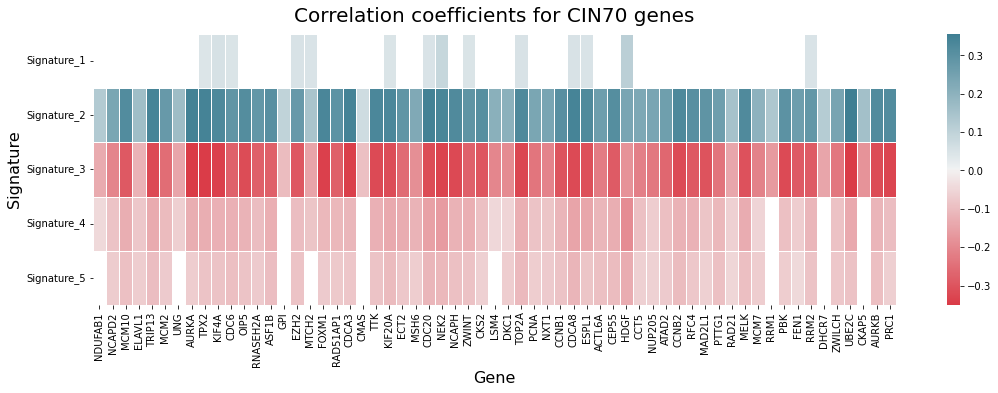

In [99]:
palette = sns.diverging_palette(10, 220, as_cmap=True)

plt.figure(figsize=(18, 5))
ax = sns.heatmap(correlation_df_70[correlation_df_70!=0], cmap=palette, linewidths=0.5)
ax.tick_params(axis="both", which="major", labelsize=10)
plt.xlabel('Gene', fontsize=16)
plt.ylabel('Signature', fontsize=16)
plt.title("Correlation coefficients for CIN70 genes", fontsize=20, y=1.02)
plt.savefig('../figures/cin70_heatmap.pdf')
plt.show()